In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import numpy as np
import torch
import torch.nn as nn
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 匯入資料

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Final Project/Final_Dataset/Second clean in Spark/clean_long_dataset.csv')

In [ ]:
df

,date,category,name,open,high,low,close,volume,year,month,day,dayofyear,weekofyear,dayofweek,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,leadsine,ht_trendmode,add,div,max23,maxindex,min25,minindex,min27,max28,minidx,maxidx,mult,sub,sum,atan,ceil,cos,cosh,exp,floor,...,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,avgprice,medprice,typprice,wclprice,beta,correl,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv,bias,ama,psy,dpo,vhf,rvi,BCI,BCTI,BDI,BDTI,BPI,BSI,NTD/USD
0,2011-05-19,Plastic,1301.TW,72.125885,72.750353,71.501417,72.125885,6510400.0,2011.0,5.0,19.0,139.0,20.0,3.0,23.992731,232.782864,2.029821,-1.760668,-0.796349,-0.990788,1.0,144.251770,1.017467,73.062576,75.0,64.944511,62.0,64.944511,73.062576,62.0,75.0,5201.753329,1.248935,2080.410141,1.556933,73.0,-0.991465,1.054008e+31,2.108016e+31,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.125885,72.125885,72.125885,72.125885,0.074218,0.959444,71.590625,1.375881,71.278387,0.024018,0.774945,71.614643,0.600540,1.831666,2.539541,1.248935,2.102069e+08,8.229290e+06,159411200.0,0.013380,5.606583,50.000000,0.879936,0.288889,0.247496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-05-20,Plastic,1301.TW,72.750339,72.750339,71.189173,71.501404,4319120.0,2011.0,5.0,20.0,140.0,20.0,4.0,23.607954,240.266807,0.613696,-3.574650,-0.868344,-0.964710,1.0,143.939511,1.021930,73.062576,75.0,64.944511,62.0,64.944511,73.062576,62.0,75.0,5179.036427,1.561166,2085.718094,1.556811,72.0,-0.728116,5.644625e+30,1.128925e+31,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.047814,71.969756,71.813638,71.735580,-0.249004,0.962657,71.840409,4.551278,70.805579,0.079602,0.754549,71.920011,0.569345,1.812345,2.534698,1.561166,2.076154e+08,6.233311e+06,155092080.0,0.004386,5.470199,50.000000,0.141915,0.285714,0.199965,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-05-23,Plastic,1301.TW,70.252476,72.438110,70.252476,72.438110,7646080.0,2011.0,5.0,23.0,143.0,21.0,0.0,23.133928,238.479280,-0.788921,-1.761952,-0.852451,-0.972454,1.0,142.690587,1.031111,73.062576,75.0,64.944511,62.0,64.944511,73.062576,62.0,75.0,5088.956620,2.185634,2092.899445,1.556992,73.0,-0.983578,1.440262e+31,2.880525e+31,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.345293,71.345293,71.709566,71.891702,-0.062922,0.961160,72.286455,8.431269,70.359532,0.148225,0.364125,72.434680,0.132587,1.839008,2.538730,2.185634,2.152615e+08,7.282952e+06,162738160.0,0.015984,5.346805,50.000000,0.823159,0.282608,0.212389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-05-24,Plastic,1301.TW,71.813635,71.813635,70.252469,71.501404,9470240.0,2011.0,5.0,24.0,144.0,21.0,1.0,22.571787,211.664731,-0.569715,1.671873,-0.524948,-0.973037,1.0,142.066104,1.022222,73.062576,75.0,64.944511,62.0,64.944511,73.062576,62.0,75.0,5045.085153,1.561166,2098.831863,1.556811,72.0,-0.728116,5.644625e+30,1.128925e+31,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.345286,71.033052,71.189169,71.267228,-0.198757,0.961071,72.268612,7.891915,70.466583,0.138618,0.423537,72.407230,0.179384,1.863768,2.606617,2.185642,2.209436e+08,8.858227e+06,153267920.0,0.001093,5.190189,50.000000,-0.255472,0.285714,0.257994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-05-25,Plastic,1301.TW,71.189196,71.501427,70.252491,70.564728,6507280.0,2011.0,5.0,25.0,145.0,21.0,2.0,22.067440,199.161755,0.792335,1.921490,-0.328236,-0.900028,1.0,141.753918,1.017778,73.062576,75.0,64.944511,65.0,64.944511,73.062576,65.0,75.0,5023.153383,1.248936,2104.452080,1.556626,71.0,0.120811,2.212289e+30,4.424578e+30,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.876960,70.876959,70.772882,70.720843,0.114643,0.954511,71.902856,4.512210,70.876946,0.078916,0.642924,71.981772,0.413351,1.819851,2.578981,1.248936,2.176900e+08,7.662124e+06,146760640.0,-0.012885,4.973624,45.833333,-1.106995,0.282608,0.169898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
df = df.drop(['key_0'], axis='columns')

In [ ]:
# 保留前 100 row 空值小於等於 60% 的 column
df = df[df.columns[df.iloc[:101,:].isnull().sum()/100 <= 0.6]]

In [ ]:
# 刪除前 58 row 當新的 df
df.drop([x for x in range(58)], axis='index', inplace=True)

In [ ]:
# index reset
df.reset_index(drop=True, inplace=True)

In [ ]:
df = df.iloc[:,:5]

In [ ]:
df.shape[1]

5

## 整理資料

In [ ]:
# 取2603 的 開、高、低、收、量
ship_2603 = df[df['name']=='2603.TW'].dropna(axis=1).loc[:,'open':'volume']
print(ship_2603)
df = ship_2603

             open        high         low       close       volume
48720   20.587770   20.626325   19.970908   20.009462   41269499.0
48721   20.279338   20.279338   19.238384   19.662477   28470080.0
48722   19.431154   19.816692   19.315492   19.546814   15967934.0
48723   19.546814   19.855247   19.469709   19.855247    9984286.0
48724   19.855249   19.855249   19.276940   19.508263   15785273.0
...           ...         ...         ...         ...          ...
51151  136.500000  152.000000  136.000000  152.000000  133713564.0
51152  157.000000  160.000000  151.000000  160.000000  134596407.0
51153  168.000000  176.000000  168.000000  176.000000   92307564.0
51154  180.000000  185.000000  170.000000  179.500000  147367246.0
51155  181.500000  197.000000  181.500000  197.000000  124635805.0

[2436 rows x 5 columns]


In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

## 模型 def

In [ ]:
def split_data(stock, lookback, gapspace=0, test_set_size=120):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1-gapspace,:]
    y_train = data[:train_set_size,-1,3:4]
    x_test = data[train_set_size:,:-1-gapspace,:]
    y_test = data[train_set_size:,-1,3:4]
    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)
    
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train= torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test= torch.from_numpy(y_test).type(torch.Tensor)
    
    x_train = x_train.to(device)
    y_train= y_train.to(device)
    x_test = x_test.to(device)
    y_test= y_test.to(device)
    
    return x_train, y_train, x_test, y_test

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim 
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
def LSTM_train_predict_tt(epochs, x_train, y_train, x_test, y_test):
      
    mseloss_train = np.zeros(epochs)
    mseloss_test = np.zeros(epochs)
    all_y_train_pred = []
    all_y_test_pred = []

    for i in range(epochs):
        
        y_train_pred = modelL(x_train)
        loss = criterion(y_train_pred, y_train) 
        if (i+1)%10 == 0:
            print("Epoch ", i+1, "MSE: ", loss.item())
        mseloss_train[i] = loss.item()
        #all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))
        all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                 
                         
        optimiserL.zero_grad()
        loss.backward()
        optimiserL.step()
        
        y_test_pred = modelL(x_test)
        losst = criterion(y_test_pred, y_test) 
        mseloss_test[i] = losst.item()
        #all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
        all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
    return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [ ]:
def GRU_train_predict_tt(epochs, x_train, y_train, x_test, y_test):
      
    mseloss_train = np.zeros(epochs)
    mseloss_test = np.zeros(epochs)
    all_y_train_pred = []
    all_y_test_pred = []

    for i in range(epochs):
        
        y_train_pred = modelG(x_train)
        loss = criterion(y_train_pred, y_train) 
        if (i+1)%10 == 0:
            print("Epoch ", i+1, "MSE: ", loss.item())
        mseloss_train[i] = loss.item()
        #all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))
        all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                 
                         
        optimiserG.zero_grad()
        loss.backward()
        optimiserG.step()

        y_test_pred = modelG(x_test)
        losst = criterion(y_test_pred, y_test) 
        mseloss_test[i] = losst.item()
        #all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
        all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
    return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

# START

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
scalertar = MinMaxScaler()
scalertar_data = scalertar.fit_transform(df.iloc[:,3].values.reshape(-1, 1))

In [ ]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df.values)

In [ ]:
modelL = LSTM(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
modelG = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)

modelL = modelL.to(device)
modelG = modelG.to(device)

criterion = torch.nn.MSELoss(reduction='mean')
optimiserL = torch.optim.Adam(modelL.parameters(), lr=0.01)
optimiserG = torch.optim.Adam(modelG.parameters(), lr=0.01)

### LSTM

In [ ]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=20, gapspace=0, test_set_size=120)

x_train.shape =  (2296, 19, 5)
y_train.shape =  (2296, 1)
x_test.shape =  (120, 19, 5)
y_test.shape =  (120, 1)


In [ ]:
all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = LSTM_train_predict_tt(epochs=500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Epoch  10 MSE:  0.0014638373395428061
Epoch  20 MSE:  0.0004991608439013362
Epoch  30 MSE:  0.00032356695737689734
Epoch  40 MSE:  0.0002551745856180787
Epoch  50 MSE:  0.00022408372024074197
Epoch  60 MSE:  0.00020809180568903685
Epoch  70 MSE:  0.0001960872032213956
Epoch  80 MSE:  0.00018219364574179053
Epoch  90 MSE:  0.00015779989189468324
Epoch  100 MSE:  8.925432484829798e-05
Epoch  110 MSE:  3.951509643229656e-05
Epoch  120 MSE:  1.7589694834896363e-05
Epoch  130 MSE:  1.4538672076014336e-05
Epoch  140 MSE:  1.0772345376608428e-05
Epoch  150 MSE:  9.199316991725937e-06
Epoch  160 MSE:  8.245151548180729e-06
Epoch  170 MSE:  7.572743015771266e-06
Epoch  180 MSE:  7.1635995482211e-06
Epoch  190 MSE:  6.887884865136584e-06
Epoch  200 MSE:  6.6654165493673645e-06
Epoch  210 MSE:  6.472858785855351e-06
Epoch  220 MSE:  6.300607310549822e-06
Epoch  230 MSE:  6.143362497823546e-06
Epoch  240 MSE:  5.999679160595406e-06
Epoch  250 MSE:  5.869321284990292e-06
Epoch  260 MSE:  5.75192598

In [ ]:
# invert predictions
#y_train_pred = scalertar.inverse_transform(y_train_pred.detach().numpy())
#y_train = scalertar.inverse_transform(y_train.detach().numpy())
y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())

#y_test_pred = scalertar.inverse_transform(y_test_pred.detach().numpy())
#y_test = scalertar.inverse_transform(y_test.detach().numpy())
y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())


In [ ]:
import math, time
from sklearn.metrics import mean_squared_error, r2_score

allTrainRMSE = []
allTestRMSE = []

for i in range(len(all_y_train_pred)):
    allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
    allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))

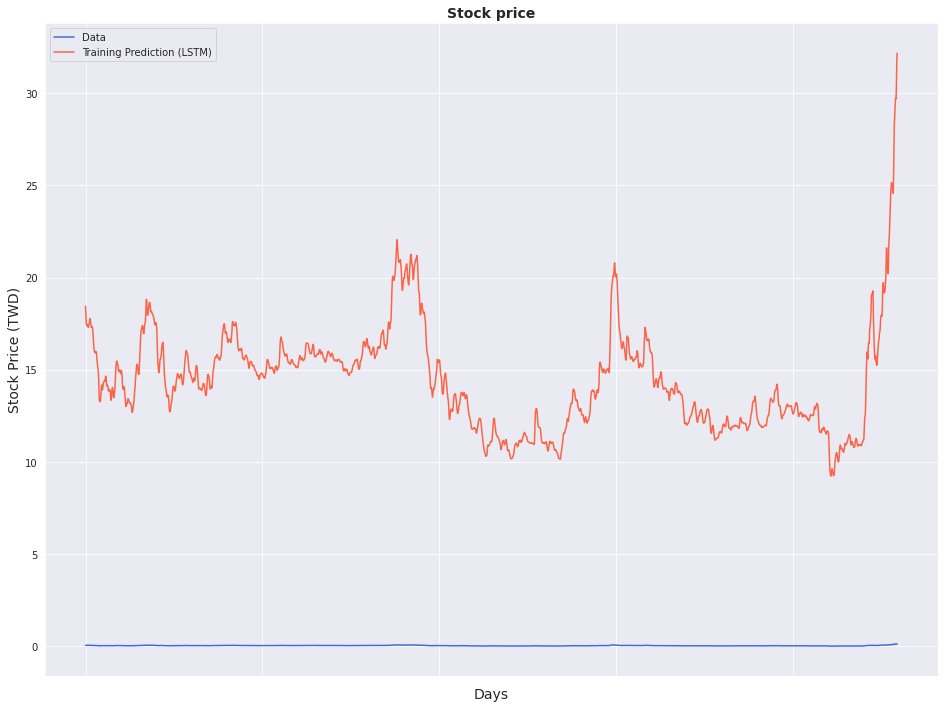

In [ ]:
plt.figure(figsize=(16, 12))

ax = sns.lineplot(data=y_train.ravel(), label="Data", color='royalblue')
ax = sns.lineplot(data=all_y_train_pred[-1].ravel(), label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Stock Price (TWD)", size = 14)
ax.set_xticklabels('', size=10)

plt.show()

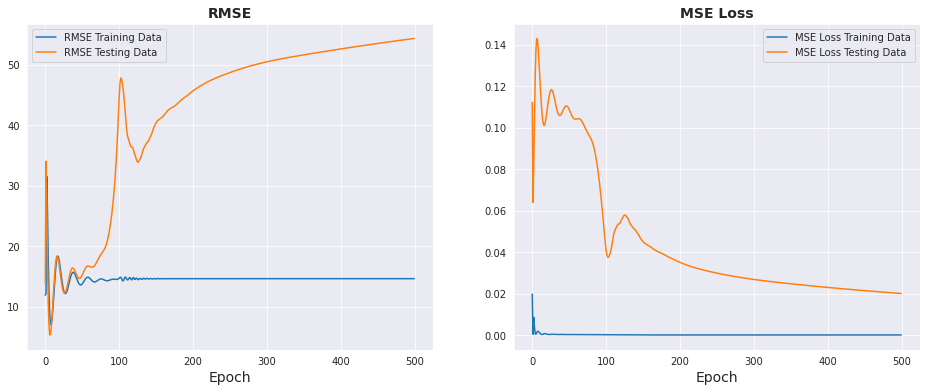

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(data=allTrainRMSE, label="RMSE Training Data")
ax = sns.lineplot(data=allTestRMSE, label="RMSE Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("RMSE", size = 14, fontweight='bold')

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=mseloss_train, label="MSE Loss Training Data")
ax = sns.lineplot(data=mseloss_test, label="MSE Loss Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("MSE Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

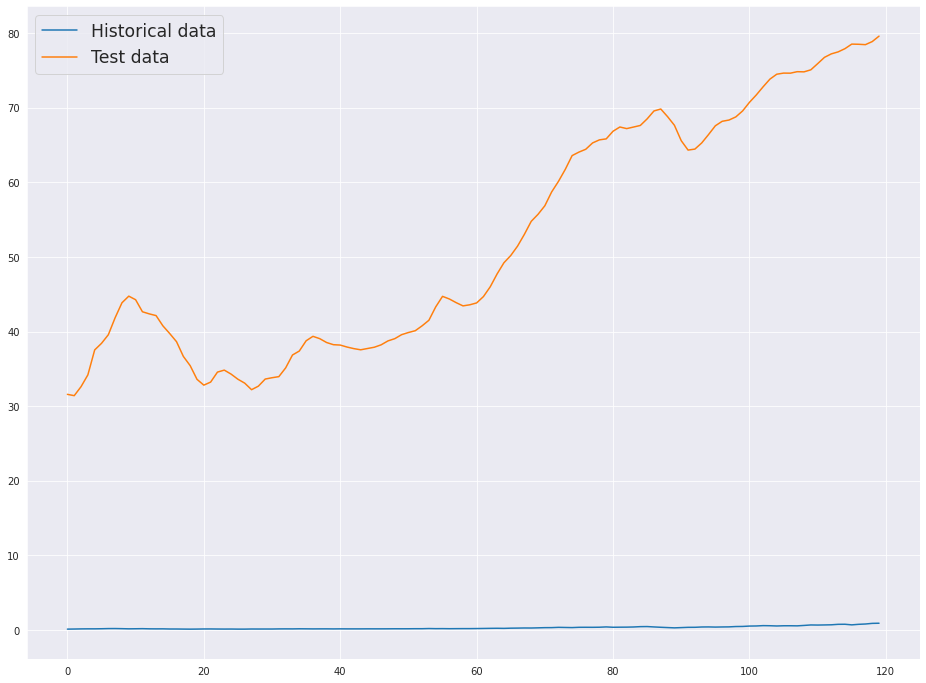

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(all_y_test_pred[-1], label='Test data')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
# calculate root mean squared error
trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))


trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])


trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))


ldf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
                    'R2 Score': [trainR2, testR2],
                    'Adj R2 Score': [trainAdjR2, testAdjR2]},
                   index=['Train', 'Test'])

ldf

# lstm.append(trainScore)
# lstm.append(testScore)
# lstm.append(training_time)

,RMSE,R2 Score,Adj R2 Score
Train,14.621878,-962240.024484,-964340.987420
Test,54.304637,-77154.906320,-80538.937298


In [ ]:
lstmdata = all_y_test_pred[-1]
lstmdata

array([[31.584795],
       [31.408   ],
       [32.614468],
       [34.193966],
       [37.537384],
       [38.420288],
       [39.574005],
       [41.861168],
       [43.859276],
       [44.74551 ],
       [44.2665  ],
       [42.654045],
       [42.371037],
       [42.139393],
       [40.76581 ],
       [39.73403 ],
       [38.640854],
       [36.66888 ],
       [35.429443],
       [33.59803 ],
       [32.817856],
       [33.227074],
       [34.56473 ],
       [34.831818],
       [34.29535 ],
       [33.609776],
       [33.082806],
       [32.207615],
       [32.68244 ],
       [33.632477],
       [33.811592],
       [33.957443],
       [35.131386],
       [36.856804],
       [37.389618],
       [38.76305 ],
       [39.36017 ],
       [39.04617 ],
       [38.531944],
       [38.239193],
       [38.18891 ],
       [37.924004],
       [37.712223],
       [37.555225],
       [37.728245],
       [37.899605],
       [38.22261 ],
       [38.747612],
       [39.046947],
       [39.582424],


### GRU

In [ ]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=20, gapspace=0, test_set_size=120)

x_train.shape =  (2368, 19, 5)
y_train.shape =  (2368, 1)
x_test.shape =  (120, 19, 5)
y_test.shape =  (120, 1)


In [ ]:
all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = GRU_train_predict_tt(epochs=500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Epoch  10 MSE:  0.004142256919294596
Epoch  20 MSE:  0.001449689851142466
Epoch  30 MSE:  0.00020063463307451457
Epoch  40 MSE:  0.00015507196076214314
Epoch  50 MSE:  9.066547499969602e-05
Epoch  60 MSE:  7.098052446963266e-05
Epoch  70 MSE:  6.816993118263781e-05
Epoch  80 MSE:  6.333000055747107e-05
Epoch  90 MSE:  6.062047395971604e-05
Epoch  100 MSE:  5.903107739868574e-05
Epoch  110 MSE:  5.7880202803062275e-05
Epoch  120 MSE:  5.703140050172806e-05
Epoch  130 MSE:  5.633106775349006e-05
Epoch  140 MSE:  5.569044878939167e-05
Epoch  150 MSE:  5.512253846973181e-05
Epoch  160 MSE:  5.460233660414815e-05
Epoch  170 MSE:  5.412477548816241e-05
Epoch  180 MSE:  5.368225174606778e-05
Epoch  190 MSE:  5.3270632633939385e-05
Epoch  200 MSE:  5.288619649945758e-05
Epoch  210 MSE:  5.252590563031845e-05
Epoch  220 MSE:  5.2187264373060316e-05
Epoch  230 MSE:  5.186816997593269e-05
Epoch  240 MSE:  5.156682163942605e-05
Epoch  250 MSE:  5.128169868839905e-05
Epoch  260 MSE:  5.101145143271

In [ ]:
# invert predictions
#y_train_pred = scalertar.inverse_transform(y_train_pred.detach().numpy())
#y_train = scalertar.inverse_transform(y_train.detach().numpy())
y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())

#y_test_pred = scalertar.inverse_transform(y_test_pred.detach().numpy())
#y_test = scalertar.inverse_transform(y_test.detach().numpy())
y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())


In [ ]:
import math, time
from sklearn.metrics import mean_squared_error, r2_score

allTrainRMSE = []
allTestRMSE = []

for i in range(len(all_y_train_pred)):
    allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
    allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))

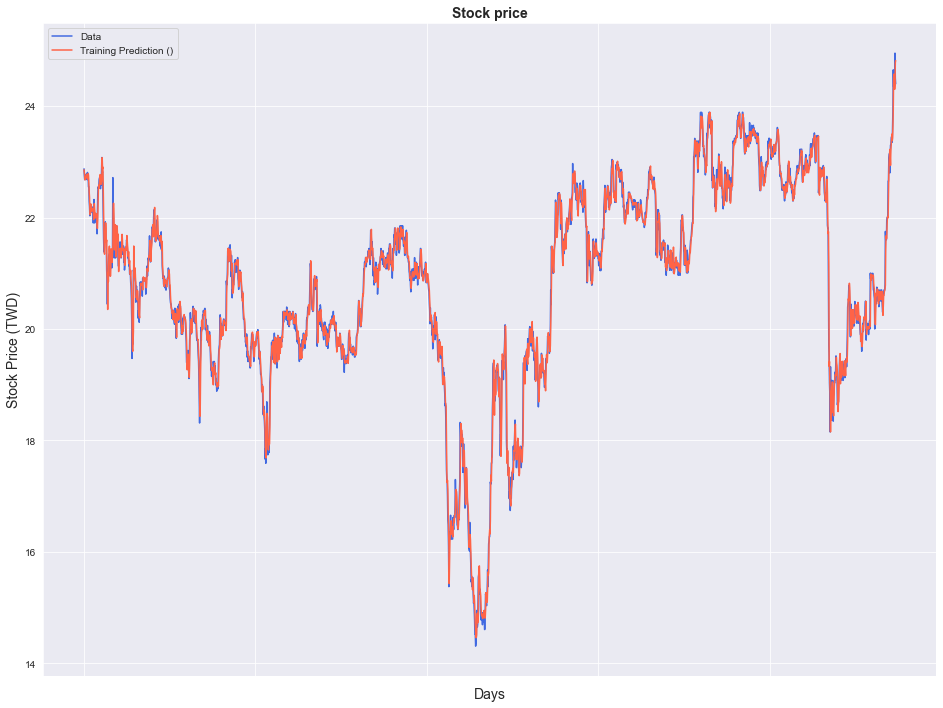

In [ ]:
plt.figure(figsize=(16, 12))

ax = sns.lineplot(data=y_train.ravel(), label="Data", color='royalblue')
ax = sns.lineplot(data=all_y_train_pred[-1].ravel(), label="Training Prediction ()", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Stock Price (TWD)", size = 14)
ax.set_xticklabels('', size=10)

plt.show()

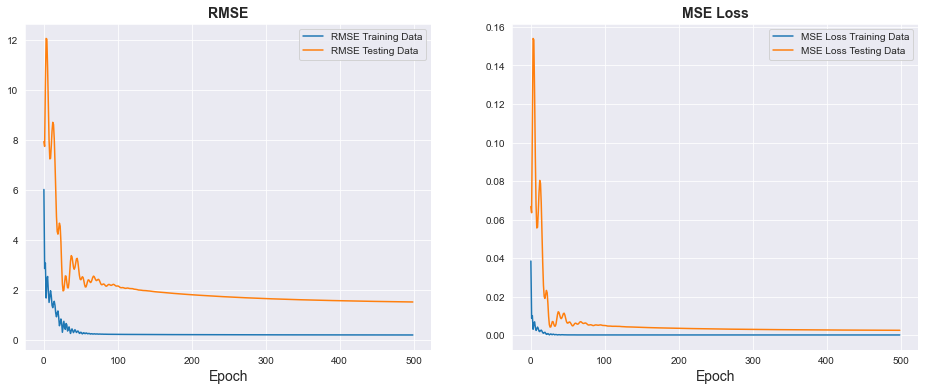

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(data=allTrainRMSE, label="RMSE Training Data")
ax = sns.lineplot(data=allTestRMSE, label="RMSE Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("RMSE", size = 14, fontweight='bold')

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=mseloss_train, label="MSE Loss Training Data")
ax = sns.lineplot(data=mseloss_test, label="MSE Loss Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("MSE Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

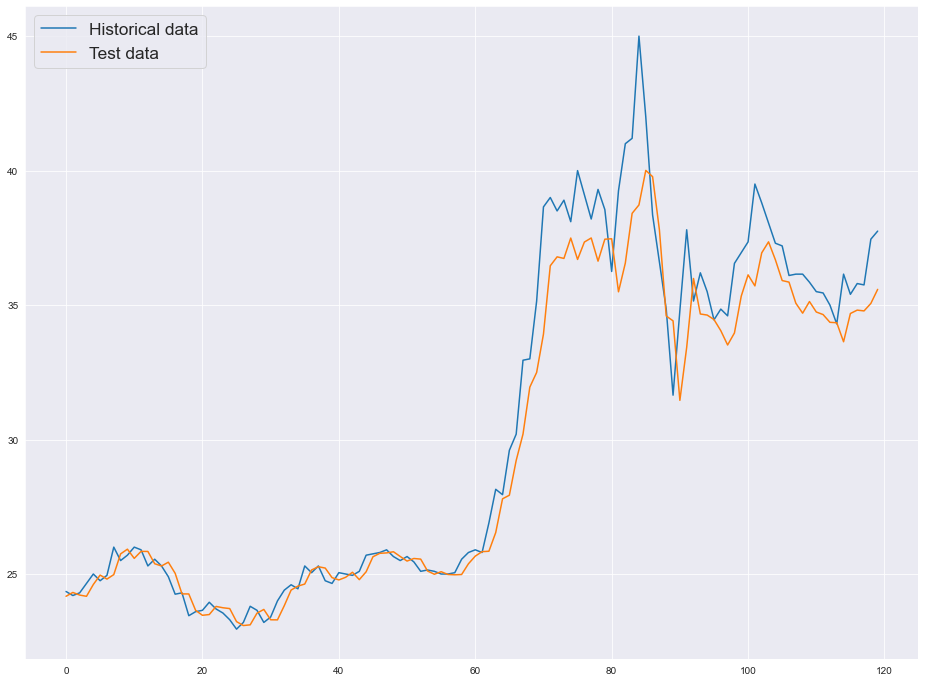

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(all_y_test_pred[-1], label='Test data')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
# calculate root mean squared error
trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))


trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])


trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))


gdf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
                    'R2 Score': [trainR2, testR2],
                    'Adj R2 Score': [trainAdjR2, testAdjR2]},
                   index=['Train', 'Test'])

gdf

# lstm.append(trainScore)
# lstm.append(testScore)
# lstm.append(training_time)

,RMSE,R2 Score,Adj R2 Score
Train,0.210811,0.986644,0.986616
Test,1.527784,0.939792,0.937152


In [ ]:
ldf

,RMSE,R2 Score,Adj R2 Score
Train,0.227812,0.984403,0.984370
Test,2.258311,0.868448,0.862679


In [ ]:
grudata = all_y_test_pred[-1]

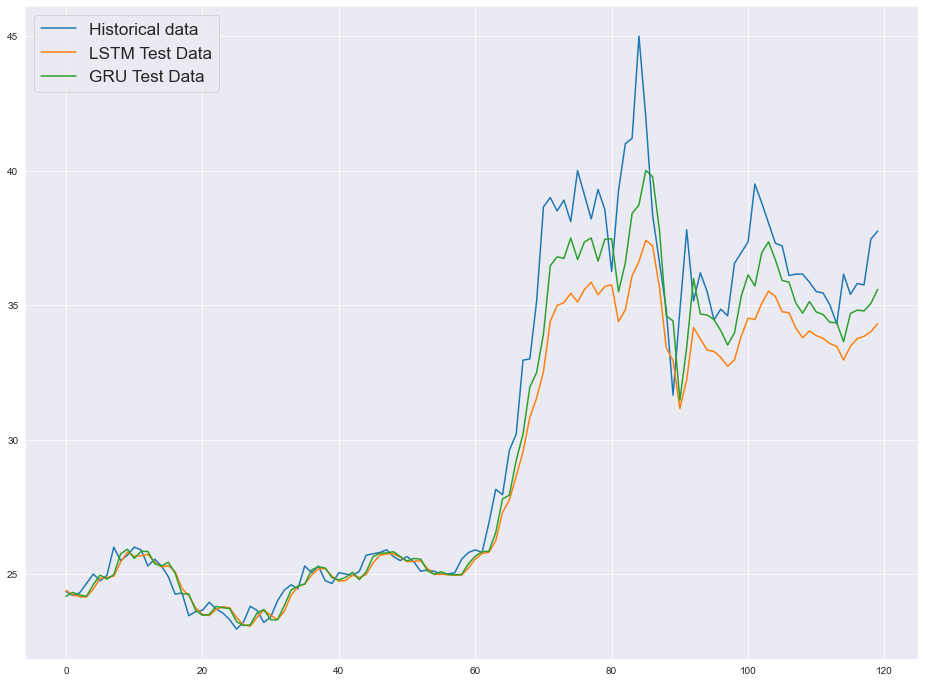

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(lstmdata, label='LSTM Test Data')
plt.plot(grudata, label='GRU Test Data')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()